In [1]:
import os
import random
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.layers import Input, LSTM, Dense
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

In [2]:
%run '/content/drive/MyDrive/Colab Notebooks/config.ipynb'

In [3]:
annotations_file = "/content/drive/MyDrive/annotations.txt"
captions = {}

with open(annotations_file, 'r') as file:
   for line in file:
        video_folder, caption = line.strip().split(' ', 1)  # Split by the first space only
        if video_folder in captions:
            captions[video_folder].append(caption)
        else:
            captions[video_folder] = [caption]

In [4]:
x = captions.keys()
print(x)

dict_keys(['-4wsuPCjDBc_5_15', '-7KMZQEsJW4_205_208', '-8y1Q0rA3n8_108_115', '-8y1Q0rA3n8_95_102', '-9CUm-2cui8_39_44', '-AwoiGR6c8M_10_14', '-Cv5LsqKUXc_17_25', '-Cv5LsqKUXc_71_76', '-DKuLXYoY3g_14_20', '-DRy7rBg0IQ_31_37', '-FugkxLmGO4_5_16', '-Ms9tsWmhyU_80_95', '-YI0cxuNcq8_262_272', '-_aaMGK6GGw_57_61', '-_hbPLsZvvo_172_179', '-_hbPLsZvvo_18_25', '-_hbPLsZvvo_19_25', '-_hbPLsZvvo_19_26', '-_hbPLsZvvo_211_219', '-_hbPLsZvvo_269_275', '-_hbPLsZvvo_288_305', '-_hbPLsZvvo_323_328', '-_hbPLsZvvo_43_55', '-_hbPLsZvvo_49_55', '-_hbPLsZvvo_5_8', '-bjOB4zS0uE_100_105', '-dm-ds5rRaM_44_52', '-joBOHlg5J0_72_80', '-mAoVOhKy0c_4_9', '-pUwIypksfE_13_23', '-rkErLY0rRc_26_35', '-rkErLY0rRc_63_67', '-rvjK0lE3z4_33_43', '-s4-6QTT7HE_235_241', '-t-ZWaJeH-o_0_15', '-uT_1VDvXok_8_15', '-vKO3uSG6Do_3_14', '-vg3vR86fu0_1_6', '-wa0umYJVGg_100_115', '-wa0umYJVGg_117_123', '-wa0umYJVGg_139_157', '-wa0umYJVGg_168_176', '-wa0umYJVGg_23_41', '-wa0umYJVGg_271_276', '-wa0umYJVGg_286_290', '-zOrV-5vh1A_69_76', '

In [5]:
# Load video features from the "feature-train-final" folder
feature_directory = "/content/drive/MyDrive/feature-train-final"
video_features = os.listdir(feature_directory)

# Create a new caption dictionary for videos that have features
filtered_captions = {}

# select only the first 200 video features
selected_video_features = video_features[:200]

for video_feature_file in selected_video_features:
  video_name = os.path.splitext(video_feature_file)[0]

  if video_name in captions:
    filtered_captions[video_name] = captions[video_name]

In [6]:
filtered_captions

{'NFxWwI0J3As_78_84': ['a girl is riding a horse bareback',
  'a woman is riding on a horse',
  'a woman is riding her horse in a field',
  'a girl is riding a pony',
  'a woman is riding on a horse',
  'a woman is riding a horse down a lawn',
  'a girl rides a horse across a field',
  'a girl is riding a horse',
  'a girl riding horseback',
  'a woman is riding a white horse in an open green field',
  'a lady riding a horse with no hands',
  'the girl and the horse galloped along',
  'the girl is riding the horse',
  'a girl is riding a horse',
  'the girl trotted on the horse',
  'a couple of young women riding a palamino horse',
  'a girl is going horse ride',
  'a girl is rading a horse',
  'a girl is riding a horse',
  'a woman is riding a horse in a field',
  'a woman is riding a horse',
  'one girl riding on a horse',
  'pretty girl ridding a horse',
  'this is white horse',
  'when the women glowing we are proud',
  'woman riding a horse',
  'a girl is riding a horse on the gra

In [7]:
filtered_captions.items()

dict_items([('NFxWwI0J3As_78_84', ['a girl is riding a horse bareback', 'a woman is riding on a horse', 'a woman is riding her horse in a field', 'a girl is riding a pony', 'a woman is riding on a horse', 'a woman is riding a horse down a lawn', 'a girl rides a horse across a field', 'a girl is riding a horse', 'a girl riding horseback', 'a woman is riding a white horse in an open green field', 'a lady riding a horse with no hands', 'the girl and the horse galloped along', 'the girl is riding the horse', 'a girl is riding a horse', 'the girl trotted on the horse', 'a couple of young women riding a palamino horse', 'a girl is going horse ride', 'a girl is rading a horse', 'a girl is riding a horse', 'a woman is riding a horse in a field', 'a woman is riding a horse', 'one girl riding on a horse', 'pretty girl ridding a horse', 'this is white horse', 'when the women glowing we are proud', 'woman riding a horse', 'a girl is riding a horse on the grass', 'a girl is riding a horse outside',

In [8]:
class VideoDescriptionTrain():
  """
  Initialize the parameters for the model
  """

  def __init__(self):
    self.train_path = train_path
    self.test_path = test_path
    self.max_length = max_length
    self.batch_size = batch_size
    self.lr = learning_rate
    self.epochs = epochs
    self.latent_dim = latent_dim
    self.validation_split = validation_split
    self.num_encoder_tokens = num_encoder_tokens
    self.num_decoder_tokens = num_decoder_tokens
    self.time_steps_encoder = time_steps_encoder
    self.time_steps_decoder = time_steps_decoder
    self.x_data = {}

    # processed data
    self.tokenizer = None

    self.save_model_path = save_model_path

  def preprocessing(self):
    """
    Preprocessing the data
    """
    train_list = []
    vocab_list = []

    for video, captions in filtered_captions.items():
      for caption in captions:
        # Process each caption within the list for the video
        caption = f"<bos> {caption} <eos>"
        if len(caption.split()) > 10 or len(caption.split()) < 6:
          continue
        else:
          train_list.append([caption, video])

    random.shuffle(train_list)
    training_list = train_list[int(len(train_list) * self.validation_split): ]
    validation_list = train_list[ :int(len(train_list) * self.validation_split)]
    for train in training_list:
      vocab_list.append(train[0])

    self.tokenizer = Tokenizer(num_words = self.num_decoder_tokens) # This line initializes a tokenizer. A tokenizer is a tool that is used to convert text data into a numerical format.
    self.tokenizer.fit_on_texts(vocab_list)
    """
    It is used to build a vocabulary based on the text data provided to it.
    Specifically, it processes the text and collects all the unique words(tokens) from the text, creating a dictionary-like structure that maps words to unique integer indices.
    This vocabulary is essential for converting text data into numerical format.
    """

    feature_files = [f for f in os.listdir("/content/drive/MyDrive/feature-train-final") if f.endswith('.npy')] # replace the path with the actual feat-train path

    for filename in feature_files:
      video_id = os.path.splitext(filename)[0] # Extracting the video ID from the filename
      file_path = os.path.join("/content/drive/MyDrive/feature-train-final", filename) # again replace the folder_path with the actual path of the feat-train folder

      # Load the features from the file
      features = np.load(file_path, allow_pickle = True)

      # Store the features in the x_data dictionary with the video ID as the key
      self.x_data[video_id] = features

    return training_list, validation_list

  # Epoch : An epoch is one complete pass throught he entire training dataset during the training of a model.
  # Batch Size : Batch size is the number of training examples used in one iteration to update the model's parameters.
  def load_dataset(self, training_list):
    """
    Loads the dataset in batches for training
    : return: batch of data
    """
    # List to store encoder input data (video features)
    encoder_input_data = []
    # List to store decoder input data (tokenized captions)
    decoder_input_data = []
    # List to store decoder target data (tokenized captions shifted by one)
    decoder_target_data = []
    #List to store video IDs
    videoID = []
    # List to store tokenized captions
    videoSeq = []

    for idx, cap in enumerate(training_list):
      caption = cap[0] # Extract the caption from the training list
      videoID.append(cap[1]) # Extract the video ID and add it to the list
      videoSeq.append(caption) # Add the caption to the list of tokenized captions

    # Tokenize the captions using the tokenizer, convert to NumPy array, and pad/truncate
    train_sequences = self.tokenizer.texts_to_sequences(videoSeq)
    train_sequences = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=self.max_length)
    train_sequences = np.array(train_sequences)
    # Get the size of the training data
    file_size = len(train_sequences)
    # Initialize a variable to count batch size
    n = 0

    # Loop over the specified number of epochs
    for i in range(self.epochs):
      # Loop over the training data
      for idx in range(0,file_size):
        n += 1 # Increment the batch size counter

        # Append video features (encoder input) from x_data
        encoder_input_data.append(self.x_data[videoID[idx]])

        # Convert the tokenized captions to one-hot encoded format
        y = to_categorical(train_sequences[idx], self.num_decoder_tokens)

        # Append the one-hot encoded sequneces (decoder input and target)
        decoder_input_data.append(y[:-1]) # Exclude the last element
        decoder_target_data.append(y[1:]) # Exclude the first element

        if n == self.batch_size:
          encoder_input = np.array(encoder_input_data) # Convert to NumPy array
          decoder_input = np.array(decoder_input_data)
          decoder_target = np.array(decoder_target_data)

          # Reset batch data lists for the next batch
          encoder_input_data = []
          decoder_input_data = []
          decoder_target_data = []
          n = 0 # Reset batch size counter

          yield([encoder_input, decoder_input], decoder_target)

  def train_model(self):
    encoder_inputs = Input(shape=(self.time_steps_encoder, self.num_encoder_tokens), name="encoder_inputs")
    encoder = LSTM(self.latent_dim, return_state=True, return_sequences=True, name='encoder_lstm')
    _, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(self.time_steps_decoder, self.num_decoder_tokens), name="decoder_inputs") # set time steps of decode to max_length of 10
    decoder_lstm = LSTM(self.latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(self.num_decoder_tokens, activation='softmax', name='decoder_softmax') # number of decoder tokens should be the vocab size
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    # model.summary()

    training_list, validation_list = self.preprocessing()

    train = self.load_dataset(training_list)
    valid = self.load_dataset(validation_list)

    early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min')

    # Run training
    opt = keras.optimizers.Adam(learning_rate = 0.0003)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=0, mode="auto")

    model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')

    # To determine how many steps or batches of data should be processed during training and validation.
    # This is done to ensure that the entire training and validation datasets are used efficiently during the training process.
    validation_steps = len(validation_list)//self.batch_size
    steps_per_epoch = len(training_list)//self.batch_size

    # for i in range(self.epochs):
    #   for idx in range(0, len(training_list), self.batch_size):
    #     batch_data = training_list[idx:idx + self.batch_size]
    #     encoder_input_batch = []
    #     decoder_input_batch = []
    #     decoder_target_batch = []
    #     for cap in batch_data:
    #       caption = cap[0]
    #       video_id = cap[1]
    #       encoder_input_batch.append(self.x_data[video_id])
    #       y = to_categorical(
    #           self.tokenizer.texts_to_sequences([f"<bos> {caption} <eos>"])[0],
    #           self.num_decoder_tokens
    #       )
    #       decoder_input_batch.append(y[:-1])
    #       decoder_target_batch.append(y[1:])
    #     encoder_input_data = np.array(encoder_input_batch)
    #     decoder_input_data = np.array(decoder_input_batch)
    #     decoder_target_data = np.array(decoder_target_batch)

        # model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
        #                   validation_data=([valid[0][0][:100], valid[0][1][:100]], valid[1][:100]),
        #                   epochs=1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
        #                   callbacks=[reduce_lr, early_stopping])
        # tf.keras.backend.clear_session()
    # if not os.path.exists(self.save_model_path):
    #   os.makedirs(self.save_model_path)


    # model.fit(train, validation_data=valid, validation_steps=validation_steps, epochs=self.epochs, steps_per_epoch=steps_per_epoch, callbacks=[reduce_lr, early_stopping])
    history = model.fit(train, validation_data=valid, validation_steps=validation_steps, epochs=self.epochs, steps_per_epoch=steps_per_epoch)

    # Plotting Training Loss vs. Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Training Accuracy vs. Vaidaiton Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    if not os.path.exists(self.save_model_path):
      os.makedirs(self.save_model_path)

    model.save('/content/drive/MyDrive/model_final/S2VT250.h5')

In [12]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/model_final/S2VT250.h5')

# Print the model summary
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 80, 4096)]           0         []                            
 )                                                                                                
                                                                                                  
 decoder_inputs (InputLayer  [(None, 10, 1500)]           0         []                            
 )                                                                                                
                                                                                                  
 encoder_lstm (LSTM)         [(None, 80, 150),            2548200   ['encoder_inputs[0][0]']      
                              (None, 150),                                                    

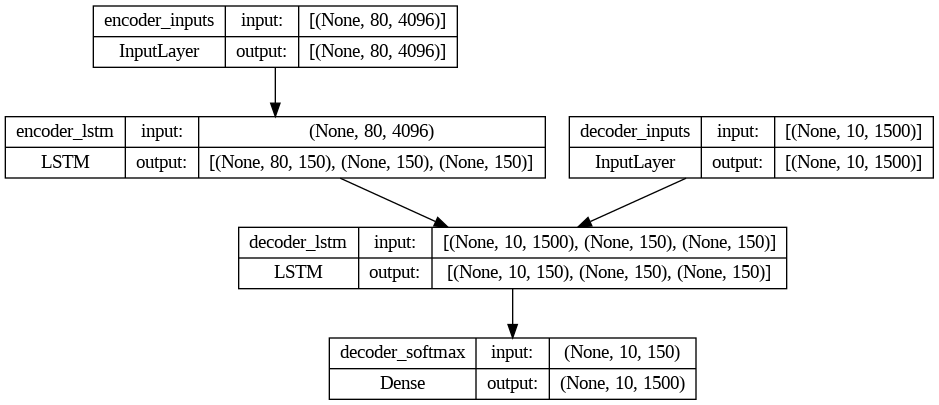

In [13]:
from keras.utils import plot_model

# Assuming 'loaded_model' is your loaded model
plot_model(loaded_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/150
16/16 [==============================] - 30s 1s/step - loss: 6.6878 - accuracy: 0.2826 - val_loss: 6.1382 - val_accuracy: 0.3321
Epoch 2/150
16/16 [==============================] - 15s 998ms/step - loss: 5.7373 - accuracy: 0.3150 - val_loss: 5.1579 - val_accuracy: 0.3332
Epoch 3/150
16/16 [==============================] - 18s 1s/step - loss: 4.7546 - accuracy: 0.3186 - val_loss: 4.2136 - val_accuracy: 0.3332
Epoch 4/150
16/16 [==============================] - 17s 1s/step - loss: 4.0442 - accuracy: 0.3191 - val_loss: 3.7536 - val_accuracy: 0.3314
Epoch 5/150
16/16 [==============================] - 15s 971ms/step - loss: 3.7794 - accuracy: 0.3183 - val_loss: 3.6210 - val_accuracy: 0.3311
Epoch 6/150
16/16 [==============================] - 17s 1s/step - loss: 3.6838 - accuracy: 0.3196 - val_loss: 3.5609 - val_accuracy: 0.3335
Epoch 7/150
16/16 [==============================] - 15s 973ms/step - loss: 3.6267 - accuracy: 0.3223 - val_loss: 3.5029 - val_accuracy: 0.3382
Epoc

16/16 [==============================] - 11s 731ms/step - loss: 1.4175 - accuracy: 0.6827
Epoch 147/150
16/16 [==============================] - 13s 845ms/step - loss: 1.4105 - accuracy: 0.6834
Epoch 148/150
16/16 [==============================] - 14s 862ms/step - loss: 1.4007 - accuracy: 0.6852
Epoch 149/150
16/16 [==============================] - 14s 856ms/step - loss: 1.4019 - accuracy: 0.6849
Epoch 150/150
16/16 [==============================] - 14s 878ms/step - loss: 1.4018 - accuracy: 0.6835


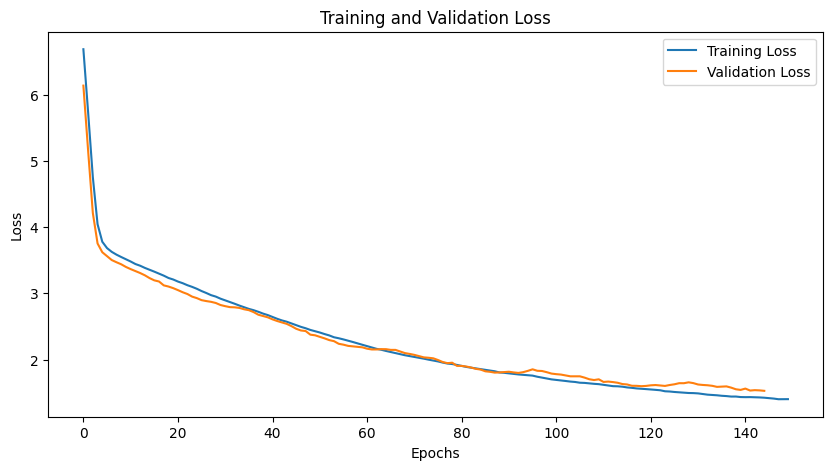

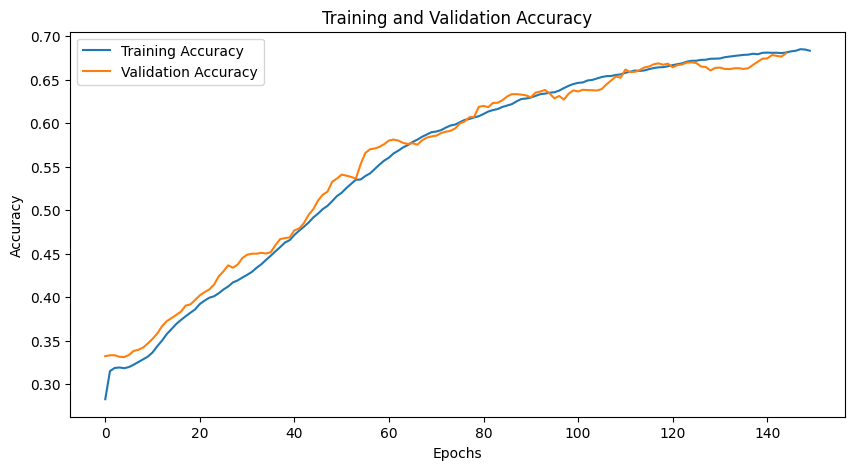

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
if __name__ == "__main__":
    video_to_text = VideoDescriptionTrain()
    video_to_text.train_model()